# Business Intelligence for Online Bidding Systems using Machine Learning

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bids_df = pd.read_csv('./data/bids.csv')
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

### Cleaning the data

In [3]:
bids_df.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [4]:
train_df.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [5]:
bids_df.shape

(7656334, 9)

In [6]:
train_df.shape

(2013, 4)

#### Checking the missing values

In [7]:
# bids_df.isnull().sum()

In bids data, the column country has some missing values.

In [8]:
# percent_missing = bids_df['country'].isnull().mean()
# print(f"Percentage of missing country data: {percent_missing*100: .2f}%")

Hence, only a small portion of data is missing in the entire dataset.

#### Distribution of the countries

In [9]:
# unique_countries = bids_df['country'].value_counts()

In [10]:
# fig, ax = plt.subplots(figsize = (15, 4))
# countries_distribution = sns.barplot(x = unique_countries.index, y = unique_countries.values, ax = ax)                        
# ax.get_xaxis().set_visible(False)

# plt.show()

We can see the distribution of the countries and find that there is one country that is significantly higher than the rest. Hence, mode imputation may be a good approach.

In [11]:
# bids_df['country'] = bids_df['country'].fillna(bids_df['country'].mode()[0])

In [12]:
# bids_df.isnull().sum()

In [13]:
# train_df.isnull().sum()

Train data does not have any missing data.

#### Analyze Dataset: The datasets are provided by two part:

1. train.csv: the base bidder dataset with labels. Besides label, it also contains unique bidder_id followed with payment_account, address and outcome;
2. bids.csv: the dataset contains some more useful information associated with unique key bid_id, corresponding with bidder_id, auction, merchandise, device, time, country, ip, and url. time and url are encrypted information.

Since both of these two files contains the unique key bidder_id, we firstly joined these data by this key. Our object is to try to find each bid is made by a human or robot, thus, we only consider the data which have bids information and labelled. We will left join on train.csv and check the joined data for missing bids information.

In [14]:
# Populate train and test data with bid details
def populate_bids(df):
    df = pd.merge(left=df, right=bids_df, how='left', left_on='bidder_id', right_on='bidder_id')
    return df

In [15]:
test = populate_bids(test_df)
test.isna().sum()

bidder_id             0
payment_account       0
address               0
bid_id               70
auction              70
merchandise          70
device               70
time                 70
country            6228
ip                   70
url                  70
dtype: int64

In [16]:
train = populate_bids(train_df)
train.isna().sum()

bidder_id             0
payment_account       0
address               0
outcome               0
bid_id               29
auction              29
merchandise          29
device               29
time                 29
country            2730
ip                   29
url                  29
dtype: int64

Data Cleaning: Since we can see all the missing values are from the variables that come from bids, we want to check if there exist some of bidder_id do not have any bids.

In [17]:
nobids_train = train[pd.isnull(train['bid_id'])]['bidder_id'].unique()
len(nobids_train)

29

In [18]:
nobids_test = test[pd.isnull(test['bid_id'])]['bidder_id'].unique()
len(nobids_test)

70

In [19]:
# Check outcome for these in the train
train[train['bidder_id'].isin(nobids_train)]['outcome']

17583      0.0
42424      0.0
129439     0.0
214915     0.0
221776     0.0
226432     0.0
255107     0.0
305088     0.0
333331     0.0
409451     0.0
654549     0.0
657208     0.0
788183     0.0
790914     0.0
794927     0.0
810369     0.0
883351     0.0
1018748    0.0
1019599    0.0
1021349    0.0
1123023    0.0
1139921    0.0
1217466    0.0
1465813    0.0
1482542    0.0
1648201    0.0
1974826    0.0
2139077    0.0
2999380    0.0
Name: outcome, dtype: float64

##### There exist 29 bidder in training data set having no bid data. After checking with their labels, they were all marked as human. Since we aim to detect robot, we will just ignore them. We will update populate_bids function.

In [20]:
# Populate train and test data with bid details
def populate_bids_with_data_cleanup(df):
    df = pd.merge(left=df, right=bids_df, how='left', left_on='bidder_id', right_on='bidder_id')
    nobids = df[pd.isnull(df['bid_id'])]['bidder_id'].unique()
    # for all the missing value observation, drop it
    df = df[~df['bidder_id'].isin(nobids)]
    return df

In [21]:
test_data = populate_bids_with_data_cleanup(test_df)
test_data.isna().sum()

bidder_id             0
payment_account       0
address               0
bid_id                0
auction               0
merchandise           0
device                0
time                  0
country            6158
ip                    0
url                   0
dtype: int64

In [22]:
train_data = populate_bids_with_data_cleanup(train_df)
train_data.isna().sum()

bidder_id             0
payment_account       0
address               0
outcome               0
bid_id                0
auction               0
merchandise           0
device                0
time                  0
country            2701
ip                    0
url                   0
dtype: int64

In [23]:
# check the missing value ratio of the country entry in train data
count_miss_ratio_train = pd.isnull(train_data['country']).sum()/len(train_data)*100
print(f" %0.2f %% observations missing country entry in train data." %
      float(count_miss_ratio_train))

 0.09 % observations missing country entry in train data.


In [24]:
# check the missing value ratio of the country entry in test data
count_miss_ratio_test = pd.isnull(test_data['country']).sum()/len(test_data)*100
print(f" %0.2f %% observations missing country entry in test data." %
      float(count_miss_ratio_test))

 0.13 % observations missing country entry in test data.


For the full data set, there is only few of observations missing country entry. We will just ignore the missing country entry data.

In [25]:
# Populate train and test data with bid details
def populate_bids_with_data_cleanup_final(df):
    df = pd.merge(left=df, right=bids_df, how='left', left_on='bidder_id', right_on='bidder_id')
    nobids = df[pd.isnull(df['bid_id'])]['bidder_id'].unique()
    # for all the missing value observation, drop it
    df = df[~df['bidder_id'].isin(nobids)]
    # remove missing country data
    df = df.dropna()
    return df

In [26]:
train = populate_bids_with_data_cleanup_final(train_df)
train.isna().sum()

bidder_id          0
payment_account    0
address            0
outcome            0
bid_id             0
auction            0
merchandise        0
device             0
time               0
country            0
ip                 0
url                0
dtype: int64

In [27]:
test = populate_bids_with_data_cleanup_final(test_df)
test.isna().sum()

bidder_id          0
payment_account    0
address            0
bid_id             0
auction            0
merchandise        0
device             0
time               0
country            0
ip                 0
url                0
dtype: int64

### Exploring data

#### Checking the unique no of each feature in train and bids data

In [28]:
print(f"Total no of row in train:          {len(train)}")
print(f"Total no of bids in train:         {len(train['bid_id'].unique())}")
print(f"Total no of bidder in train:      {len(train['bidder_id'].unique())}")
print(f"Total no of payment in train:     {len(train['payment_account'].unique())}")
print(f"Total no of address in train:     {len(train['address'].unique())}")
print(f"Total no of auction in train:     {len(train['auction'].unique())}")
print(f"Total no of merchandise in train: {len(train['merchandise'].unique())}")
print(f"Total no of device in train:      {len(train['device'].unique())}")
print(f"Total no of country in train:     {len(train['country'].unique())}")
print(f"Total no of ip in train:          {len(train['ip'].unique())}")
print(f"Total no of url in train:         {len(train['url'].unique())}")

Total no of row in train:          3068523
Total no of bids in train:         3068523
Total no of bidder in train:      1983
Total no of payment in train:     1983
Total no of address in train:     1983
Total no of auction in train:     12740
Total no of merchandise in train: 10
Total no of device in train:      5726
Total no of country in train:     198
Total no of ip in train:          1028810
Total no of url in train:         663265


In [29]:
print(f"total bids made by robots in data set: {len(train[train['outcome'] == 1])}")
print(f"total bids made by human in data set:  {len(train[train['outcome'] == 0])}")
print("the ratio of made by robot vs. bids made by human in data set: 3:20")

total bids made by robots in data set: 412153
total bids made by human in data set:  2656370
the ratio of made by robot vs. bids made by human in data set: 3:20


### Feature Engineering

In [30]:
# bidding time difference per user (bidder_id)
def calculate_bidding_time_difference_per_user(df):
    df = df.sort_values(by=['time'])
    df['timediffs'] = df.groupby('bidder_id')['time'].transform(pd.Series.diff)
    return df

In [31]:
# number of bids a user made per auction
def bids_user_made_per_auction(df):
    bids_per_auction = df.groupby(['auction', 'bidder_id']).size()
    return bids_per_auction.to_frame()

In [32]:
# proportion of bots for each country
def proportion_of_bots_for_each_country(df):
    pbots_country = df[df['outcome'] == 1].groupby('country').size()/df.groupby('country').size()
    pbots_country = pbots_country.fillna(0)
    return pbots_country.to_frame()

In [33]:
# proportion of bots per device
def proportion_of_bots_per_device(df):
    pbots_device = df[df['outcome'] == 1].groupby('device').size()/df.groupby('device').size()
    pbots_device = pbots_device.fillna(0)
    return pbots_device.to_frame()

In [34]:
# number of unique ip to number of bids ratio
def number_of_unique_ip_to_number_of_bids_ratio(df):
    ip_bids_ratio = df.groupby('bidder_id')['ip'].nunique()/df.groupby('bidder_id')['bid_id'].nunique()
    return ip_bids_ratio.to_frame()

In [35]:
from scipy import stats

def ent(data):
    p_data = data.value_counts()/len(data)  # calculates the probabilities
    # input probabilities to get the entropy
    entropy = stats.entropy(p_data)
    return entropy

In [36]:
# mean per auction url entropy for each user
# Input a pandas series
def mean_per_auctio_url_entropy_for_each_user(df):
    auction_url_entropy = df.groupby(['auction', 'bidder_id'])['url'].apply(ent)
    return auction_url_entropy.groupby('bidder_id').mean().reset_index()

In [37]:
def feature_engineering(df):
    df = df.sort_values(by=['time'])
    df['timediffs'] = df.groupby('bidder_id')['time'].transform(pd.Series.diff)
    df = pd.merge(df, bids_user_made_per_auction(df), on=['auction', 'bidder_id'], how='left')
    df = pd.merge(df, proportion_of_bots_for_each_country(df), on='country', how='left')
    df = pd.merge(df, proportion_of_bots_per_device(df), on='device', how='left')
    df = pd.merge(df, number_of_unique_ip_to_number_of_bids_ratio(df), on='bidder_id', how='left')
    df = pd.merge(df, mean_per_auctio_url_entropy_for_each_user(df), on='bidder_id', how='left')
    return df

In [38]:
train = feature_engineering(train)
train.isnull().sum()

/var/folders/rz/q4yf3l591kj4lmf27ykwkt9w0000gp/T/ipykernel_7114/3020834649.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, number_of_unique_ip_to_number_of_bids_ratio(df), on='bidder_id', how='left')


bidder_id             0
payment_account       0
address               0
outcome               0
bid_id                0
auction               0
merchandise           0
device                0
time                  0
country               0
ip                    0
url_x                 0
timediffs          1983
0_x                   0
0_y                   0
0_x                   0
0_y                   0
url_y                 0
dtype: int64

In [39]:
train.columns

Index(['bidder_id', 'payment_account', 'address', 'outcome', 'bid_id',
       'auction', 'merchandise', 'device', 'time', 'country', 'ip', 'url_x',
       'timediffs', '0_x', '0_y', '0_x', '0_y', 'url_y'],
      dtype='object')

In [40]:
# set column names
train.columns = ['bidder_id', 'payment_account', 'address', 'outcome',
               'bid_id', 'auction', 'merchandise', 'device', 'time', 'country',
               'ip', 'url', 'timediffs', 'bids_per_auction', 'pbots_country', 'pbots_device',
               'ip_bids_ratio', 'auction_url_entropy']
train.head()

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
0,76218e14c379c12d599dae9e1c00b61a3i5b2,a3d2de7675556553a5f08e4c88d2c228sjo4q,ca8d4b018cb62966eebb2974f5a83b4fstk6z,0.0,2351187.0,6hpvy,sporting goods,phone1161,9.631917e+15,cz,121.169.96.51,f33fl83l4vrg6is,NaN,368,0.089199,0.020161,0.178624,1.463760
1,6e178db6d17d21aa88aaca5bf15c2761lc500,a3d2de7675556553a5f08e4c88d2c228mqaf6,0d11440b07e5e2c8550af74b728ab4edk47gk,0.0,2351200.0,jqx39,jewelry,phone99,9.631917e+15,sa,174.12.78.255,omwhmwzvrn6ycq6,NaN,15452,0.177281,0.055360,0.583490,0.885604
2,197e90906939267ace2422e78e8e83889znqp,faef6512727719c3dd147a06ba951c947c4fn,dd7151709002fc3dce968916d8ec00ede03vc,0.0,2351192.0,gst86,home goods,phone348,9.631917e+15,ma,154.151.182.60,vasstdc27m7nks3,NaN,2386,0.095494,0.065255,0.461730,0.809338
3,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351190.0,fagyq,sporting goods,phone1,9.631917e+15,in,161.192.187.34,3skc4v2r07bneta,NaN,851,0.133801,0.056095,0.196636,1.747853
4,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351188.0,64uay,sporting goods,phone0,9.631917e+15,ke,17.120.130.121,vasstdc27m7nks3,0.0,12,0.035496,0.009222,0.196636,1.747853


In [41]:
train.timediffs = train.timediffs.fillna(0)
train.head()

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
0,76218e14c379c12d599dae9e1c00b61a3i5b2,a3d2de7675556553a5f08e4c88d2c228sjo4q,ca8d4b018cb62966eebb2974f5a83b4fstk6z,0.0,2351187.0,6hpvy,sporting goods,phone1161,9.631917e+15,cz,121.169.96.51,f33fl83l4vrg6is,0.0,368,0.089199,0.020161,0.178624,1.463760
1,6e178db6d17d21aa88aaca5bf15c2761lc500,a3d2de7675556553a5f08e4c88d2c228mqaf6,0d11440b07e5e2c8550af74b728ab4edk47gk,0.0,2351200.0,jqx39,jewelry,phone99,9.631917e+15,sa,174.12.78.255,omwhmwzvrn6ycq6,0.0,15452,0.177281,0.055360,0.583490,0.885604
2,197e90906939267ace2422e78e8e83889znqp,faef6512727719c3dd147a06ba951c947c4fn,dd7151709002fc3dce968916d8ec00ede03vc,0.0,2351192.0,gst86,home goods,phone348,9.631917e+15,ma,154.151.182.60,vasstdc27m7nks3,0.0,2386,0.095494,0.065255,0.461730,0.809338
3,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351190.0,fagyq,sporting goods,phone1,9.631917e+15,in,161.192.187.34,3skc4v2r07bneta,0.0,851,0.133801,0.056095,0.196636,1.747853
4,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351188.0,64uay,sporting goods,phone0,9.631917e+15,ke,17.120.130.121,vasstdc27m7nks3,0.0,12,0.035496,0.009222,0.196636,1.747853


### Data Visualization

In [42]:
pip install beautifultable

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from beautifultable import BeautifulTable
import warnings

In [44]:
warnings.filterwarnings('ignore')

In [45]:
bots = train.loc[train.outcome == 1]
human = train.loc[train.outcome == 0]
bots.shape, human.shape

((412153, 18), (2656370, 18))

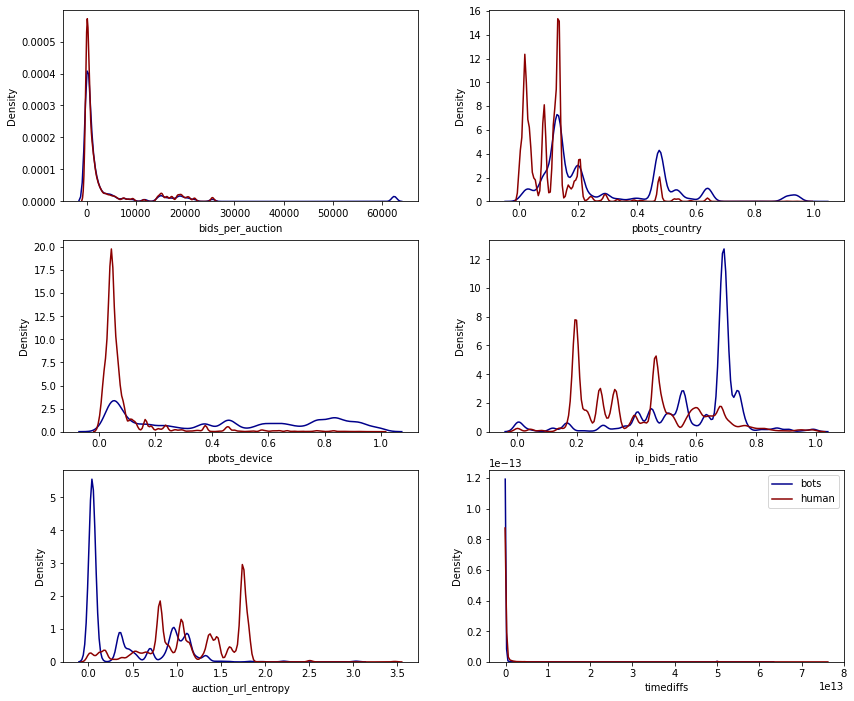

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=False)
sns.distplot(train['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])
sns.distplot(human['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])

sns.distplot(bots['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])
sns.distplot(human['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])

sns.distplot(bots['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkblue', label='bots',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])
sns.distplot(human['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkred', label='human',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])

sns.distplot(bots['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])
sns.distplot(human['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])

sns.distplot(bots['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])
sns.distplot(human['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])

sns.distplot(bots['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
sns.distplot(human['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
plt.legend(['bots', 'human'])
plt.show()

<AxesSubplot:>

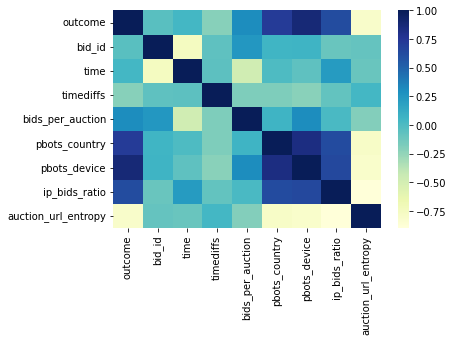

In [47]:
corr_matrix = train.corr()
sns.heatmap(corr_matrix.corr(),
            xticklabels=corr_matrix.corr().columns,
            yticklabels=corr_matrix.corr().columns,
            cmap="YlGnBu",
            fmt='d')

### Modeling

In [48]:
# for train and test data set split
from sklearn.model_selection import train_test_split
bid_train, bid_test = train_test_split(train, test_size=0.2)

##### Undersampling

From data preprocessing part, we see the ratio of the robot bidder and the human bidder is 3:20, thus we need to undersampling the human bidder samples in the trainset to keep the data balance.

In [49]:
# Balance train data
bots_train = bid_train.loc[bid_train.outcome == 1]
human_train = bid_train.loc[bid_train.outcome == 0]
human_sample = human_train.sample(n=len(bots_train))
bid_train_balance = pd.concat([bots_train, human_sample])
bid_train_balance.head()

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
2545272,67a1b129ca241c51d0abb5484f8eb3fct8o5c,a12ba564b8f968acf2efcee7087d8e4defyfl,6876549ce8193a2e92a84a50141701c4f86k4,1.0,1011094.0,m5cq4,sporting goods,phone386,9.764599e+15,us,233.198.60.214,vasstdc27m7nks3,3.157895e+08,382,0.476018,0.692879,0.633952,0.020786
2662562,e12177ff9c1a8413996f7b1a590980c82ofeo,4ceb0ecc3a5bf6988c1639c112ea88eaoit7w,acb0169abfffe7093ba53f8a4472ff4b14lk7,1.0,1309434.0,07axb,sporting goods,phone243,9.766926e+15,in,9.107.136.178,85a8kbxj9hi7mvb,2.157895e+09,169,0.133801,0.108521,0.551035,1.129438
121725,c8f537f6bb0aa2d45da541a875f014358qm7p,a3d2de7675556553a5f08e4c88d2c228avrrr,ca8d4b018cb62966eebb2974f5a83b4flnsno,1.0,2643484.0,4qcs9,sporting goods,phone435,9.632813e+15,za,77.63.173.12,qbwaw70u759wyme,3.315789e+09,137,0.086032,0.051107,0.402938,0.986332
2505202,c2e1242ad5ea781923a08987d55365c69fii7,a3d2de7675556553a5f08e4c88d2c228ck7kd,186e3af2ea3d97f854014c021ee14734wun94,1.0,913297.0,19wf5,jewelry,phone28,9.764221e+15,za,201.205.219.153,fqvbxv65by2lyo3,3.157895e+08,21,0.086032,0.237663,0.450257,0.949257
1577800,c8f537f6bb0aa2d45da541a875f014358qm7p,a3d2de7675556553a5f08e4c88d2c228avrrr,ca8d4b018cb62966eebb2974f5a83b4flnsno,1.0,6199346.0,fb06y,sporting goods,phone63,9.700734e+15,ru,155.231.50.85,yzoa2so5irpskra,5.263158e+07,1912,0.206036,0.110642,0.402938,0.986332


In [50]:
train_columns = ['bids_per_auction','pbots_country','pbots_device','ip_bids_ratio','auction_url_entropy']
X_train = bid_train_balance[train_columns]
y_train = bid_train_balance['outcome']

X_test = bid_test[train_columns]
y_test = bid_test['outcome']
X_train.shape, y_train.shape

((658992, 5), (658992,))

## 1. Decision Tree

In [51]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# hyperparameter tuning
dt = tree.DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(10, 15),
    'min_samples_split': range(2, 6)
}

dt_cv = GridSearchCV(estimator=dt,
                     param_grid=param_grid,
                     cv=5)
dt_cv.fit(X_train, y_train)
print(dt_cv.best_params_)

{'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 13, 'min_samples_split': 2}


In [52]:
import time
# fit the model
# Decision Tree
start_time = time.time()
kwargs_regularize = dict(criterion='gini',
                         max_depth=5,
                         max_leaf_nodes=14,
                         min_samples_split=2)
dt = tree.DecisionTreeClassifier(**kwargs_regularize)
dt.fit(X_train, y_train)

dt_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7176179885864258 seconds ---


Feature importance of Decision Tree Model


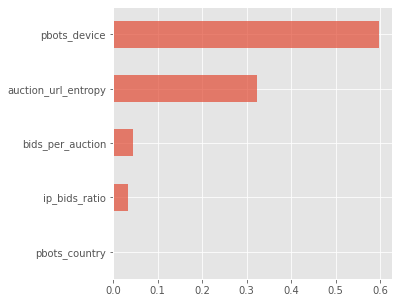

In [53]:
# Check feature importance and display in bar plot.
print('Feature importance of Decision Tree Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(dt.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)
fig.savefig('dt_feature.png')

In [54]:
y_dt_pred = dt.predict(X_test)

In [55]:
from sklearn.metrics import accuracy_score
# accuracy score
print(f"Decision Tree Accuracy: {accuracy_score(y_dt_pred, y_test):.3f}")

Decision Tree Accuracy: 0.843


#### AUC

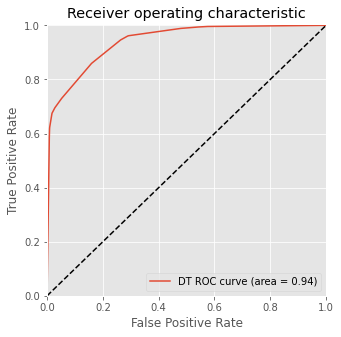

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams

# Plot ROC in one graph
y_dt_score = dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _dt = roc_curve(y_test, y_dt_score)
roc_dt_auc = auc(fpr_dt, tpr_dt)

fig = plt.figure(figsize=(5, 5))
plt.plot(fpr_dt, tpr_dt, label='DT ROC curve (area = %0.2f)' % roc_dt_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc_dt_auc.png')

#### Pecision vs Recall

In [57]:
# print('Classification Report of Decision Tree Model')
# print(classification_report(y_test, y_dt_pred))

## 2. Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50)
param_grid = {
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(8, 12),
    'max_features': ['sqrt', 'auto', 'log2']
}

rf_cv = GridSearchCV(estimator=rf,
                     param_grid=param_grid,
                     cv=5)
rf_cv.fit(X_train, y_train)
print(rf_cv.best_params_)

{'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 11}


In [98]:
start_time = time.time()

rf = RandomForestClassifier(n_estimators=100, max_depth=5,
                            max_leaf_nodes=11, max_features='log2',
                            bootstrap=True, oob_score=True)
rf.fit(X_train, y_train)

rf_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 36.052568674087524 seconds ---


Feature importance of Random Forest Model


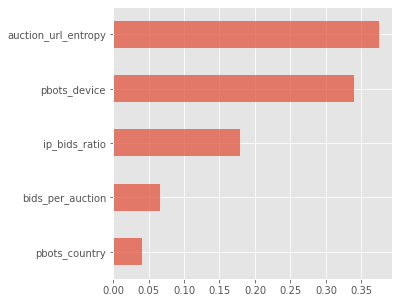

In [99]:
# Check feature importance and display in bar plot.
print('Feature importance of Random Forest Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)
fig.savefig('rf_feature.png')

In [100]:
y_rf_pred = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_rf_pred, y_test):.3f}")

Random Forest Accuracy: 0.924


#### AUC

In [62]:
# # Plot ROC in one graph
# y_rf_score = rf.predict_proba(X_test)[:, 1]
# fpr_rf, tpr_rf, _rf = roc_curve(y_test, y_rf_score)
# roc_rf_auc = auc(fpr_rf, tpr_rf)

# plt.figure(figsize=(5, 5))
# plt.plot(fpr_rf, tpr_rf, label='RF ROC curve (area = %0.2f)' % roc_rf_auc)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.005])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()
# fig.savefig('roc_rf_auc.png')

#### Precision vs. Recall

In [63]:
# print('Classification Report of Random Forest Model')
# print(classification_report(y_test, y_rf_pred))

# # KNN Algorithm


In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Plotting the K val with Cross validated score

Text(0, 0.5, 'Cross-Validated f1 Score')

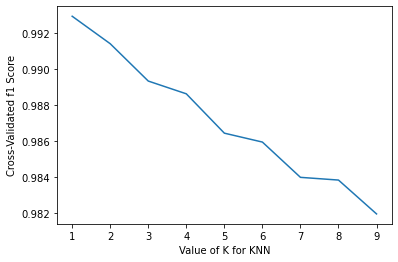

In [65]:
k_range = list(range(1, 10))
k_scores = {}
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
  k_scores[k] = scores.mean()

plt.plot(k_range, k_scores.values())
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f1 Score')

### Selecting the best value of K

In [67]:
best_k = -1
max_score = -1
for k,score in k_scores.items():
    if score > max_score:
        best_k = k
        max_score = score
print(best_k)
print(max_score)

1
0.9929132598696485


### Fitting the best value of K

In [69]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
print(metrics.f1_score(y_test, y_knn_pred, average='weighted'))

0.9915460068280932


### Accuracy 

In [73]:
print(f"KNN Accuracy: {accuracy_score(y_knn_pred, y_test):.3f}")

KNN Accuracy: 0.991


In [74]:
print('Classification Report of KNN model')
print(classification_report(y_test, y_knn_pred))

Classification Report of KNN model
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    531469
         1.0       0.94      1.00      0.97     82236

    accuracy                           0.99    613705
   macro avg       0.97      0.99      0.98    613705
weighted avg       0.99      0.99      0.99    613705



## SVM Algorithm 

In [58]:
from sklearn.svm import SVC

In [ ]:
model = SVC(kernel="linear", C=0.025)
model.fit(X_train,y_train)
y_svm_pred = model.predict(X_test)
print(metrics.f1_score(y_test, y_svm_pred, average='weighted'))

In [ ]:
print('Classification Report of SVM model')
print(classification_report(y_test, y_svm_pred))

## Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

In [52]:
y_nb_pred = gnb.predict(X_test)


In [53]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_nb_pred)))

Model accuracy score: 0.8835


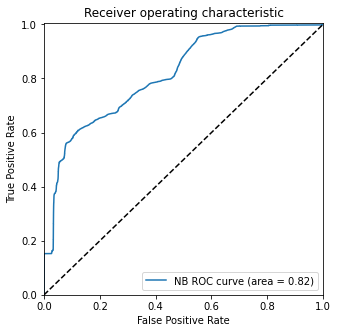

In [54]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams

# Plot ROC in one graph
y_nb_score = gnb.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _nb = roc_curve(y_test, y_nb_score)
roc_nb_auc = auc(fpr_nb, tpr_nb)

fig = plt.figure(figsize=(5, 5))
plt.plot(fpr_nb, tpr_nb, label='NB ROC curve (area = %0.2f)' % roc_nb_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc_NB_auc.png')

## Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [56]:
y_lr_pred_test = logreg.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_lr_pred_test)))

Model accuracy score: 0.8397


In [58]:
# predicting to compare the train test set accuracy
y_lr_pred_train = logreg.predict(X_train)

In [59]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_lr_pred_train)))

Training-set accuracy score: 0.7603


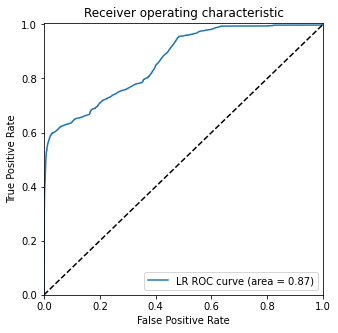

In [60]:
# Plot ROC in one graph
y_lr_score = logreg.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _lr = roc_curve(y_test, y_lr_score)
roc_lr_auc = auc(fpr_lr, tpr_lr)

fig = plt.figure(figsize=(5, 5))
plt.plot(fpr_lr, tpr_lr, label='LR ROC curve (area = %0.2f)' % roc_lr_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc_LR_auc.png')